In [1]:
import sys
import os
import time
import numpy as np
import numpy.fft as fourier
import math
import time

from gurobipy import *

import matplotlib.pyplot as plt
import matplotlib as mpl

#import matplotlib.image as mpimg
%matplotlib inline


def plot_comparison(img0, title0, img1, title1):
    fig2 = plt.figure(figsize = (20, 20))

    sub0 = fig2.add_subplot(2,2,1)
    sub0.imshow(np.transpose(img0))
    sub0.set_title(title0)

    sub1 = fig2.add_subplot(2,2,2)
    sub1.imshow(np.transpose(img1))
    sub1.set_title(title1)

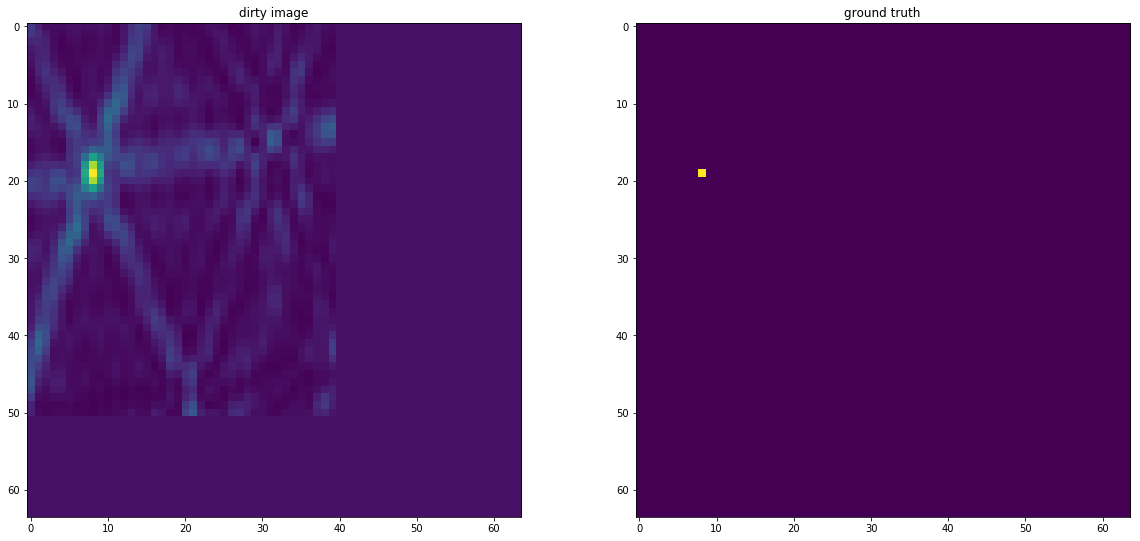

In [3]:
folder = "./img-csv/test_64.64/"

dirty_map = np.genfromtxt(folder+'dirty.csv', delimiter=',')
psf_map = np.genfromtxt(folder+'psf.csv', delimiter=',')
clean_map = np.genfromtxt(folder+'clean.csv', delimiter=',')
model_map = np.genfromtxt(folder+'model.csv', delimiter=',')

truth_map = np.zeros(dirty_map.shape)
truth_map[8,19] = 1.0

plot_comparison(dirty_map, 'dirty image', truth_map, 'ground truth')

In [7]:
def convolve2d_cutoff(D, psf):
    psf = np.flipud(np.fliplr(psf))
    convolve = np.zeros(dirty_map.shape)
    XC = int(math.floor(psf.shape[0]/2 -1))
    YC = int(math.floor(psf.shape[1]/2 -1))
    norm = psf.sum()
    for x in range(0, dirty_map.shape[0]):
        for y in range(0, dirty_map.shape[1]):
            s = 0
            for i in range(0, psf_map.shape[0]):
                for j in range(0, psf_map.shape[1]):
                    xInd = (x + i - XC)
                    yInd = (y + j - YC)
                    if xInd >= 0 and xInd < dirty_map.shape[0] and yInd >= 0 and yInd < dirty_map.shape[1]:
                        s += psf[i, j] * D[xInd,yInd]
            convolve[x,y] = s
    return convolve

In [9]:
def convolve2d_circular(D, psf):
    psf = np.flipud(np.fliplr(psf))
    convolve = np.zeros(dirty_map.shape)
    XC = int(math.floor(psf.shape[0]/2 -1))
    YC = int(math.floor(psf.shape[1]/2 -1))
    norm = psf.sum()
    for x in range(0, dirty_map.shape[0]):
        for y in range(0, dirty_map.shape[1]):
            s = 0
            for i in range(0, psf_map.shape[0]):
                for j in range(0, psf_map.shape[1]):
                    xInd = (x + i - XC) % psf_map.shape[0]
                    yInd = (y + j - YC) % psf_map.shape[1]
                    s += psf[i, j] * D[xInd,yInd]
            convolve[x,y] = s
    return convolve

In [10]:
D_FT = fourier.fft2(dirty_map)
PSF_FT = fourier.fft2(psf_map)
T_FT = fourier.fft2(truth_map)

In [12]:
#Convolution in the Fourier Domain
fourier_conv = fourier.ifft2(T_FT*PSF_FT).real
fourier_conv = np.roll(fourier_conv, int(-64/2),axis=0)
fourier_conv = np.roll(fourier_conv, int(-64/2),axis=1)

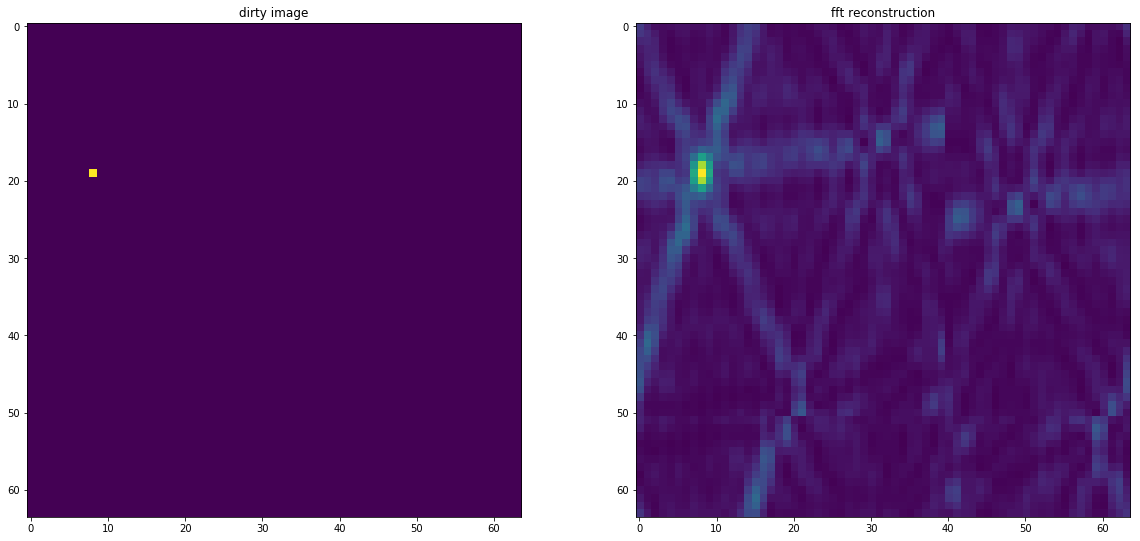

In [14]:
plot_comparison(truth_map, 'dirty image', fourier_conv, "fft reconstruction")